<a href="https://colab.research.google.com/github/netcaster1/dataanalysis/blob/main/drawing_investing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install finlab > log.txt
!pip install alphalens > log.txt
!pip install ta-lib-bin > log.txt

In [ ]:
#@title 繪製股價曲線
from IPython.display import HTML, Image
from google.colab.output import eval_js
from base64 import b64decode

canvas_html = """
<canvas width=%d height=%d style="border: solid 1px black"></canvas>
<button>Finish</button>
<script>
var canvas = document.querySelector('canvas')
var ctx = canvas.getContext('2d')
ctx.lineWidth = %d
var button = document.querySelector('button')
var mouse = {x: 0, y: 0}
var xs = []
var ys = []
canvas.addEventListener('mousemove', function(e) {
  mouse.x = e.pageX - this.offsetLeft
  mouse.y = e.pageY - this.offsetTop
})
canvas.onmousedown = ()=>{
  ctx.beginPath()
  ctx.moveTo(mouse.x, mouse.y)

  canvas.addEventListener('mousemove', onPaint)
}
canvas.onmouseup = ()=>{
  canvas.removeEventListener('mousemove', onPaint)
}
var onPaint = ()=>{
  ctx.lineTo(mouse.x, mouse.y)
  xs.push(mouse.x)
  ys.push(mouse.y)
  ctx.stroke()
}
var data = new Promise(resolve=>{
  button.onclick = ()=>{
    resolve(canvas.toDataURL('image/png'))

    const jsonContent = JSON.stringify({"x": xs, "y": ys});
    console.log(jsonContent)

    google.colab.kernel.invokeFunction(
        'notebook.save_fig', // The callback name.
        [xs, ys], // The arguments.
        {}); // kwargs
  }
})
</script>
"""

import IPython
from google.colab import output

xs = []
ys = []

def save_fig(a, b):

  global xs
  global ys
  xs = a
  ys = b
  # Use display.JSON to transfer a structured result.
  return IPython.display.JSON({'result': ' '.join((a, b))})

output.register_callback('notebook.save_fig', save_fig)

def draw(filename='drawing.png', w=400, h=200, line_width=1):
  display(HTML(canvas_html % (w, h, line_width)))
  data = eval_js("data")
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return len(binary)

draw()

3979

輸入成功!


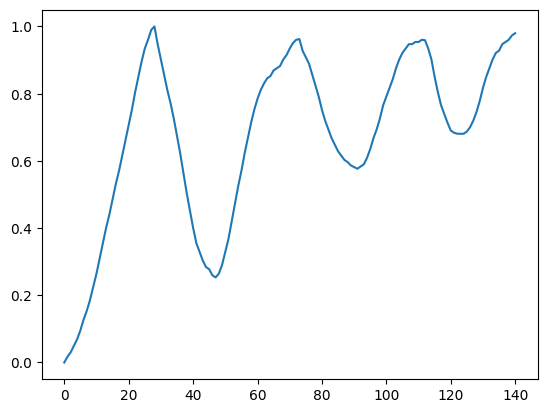

In [ ]:
#@title 畫圖選股比對
match_days =  200#@param {type:"integer"}
match_frequency = "D" #@param {type:"string"}
from finlab import data
import numpy as np
import plotly.graph_objects as go
from plotly.subplots import make_subplots


import pandas as pd

def get_price(freq, last_date=None, close_only=True):

    with data.universe('TSE_OTC'):

        close_ = data.get('price:收盤價').resample(freq).last().dropna(how='all').loc[:last_date].iloc[-len(series_):]
        vol_ = data.get('price:成交股數').resample(freq).last().dropna(how='all').loc[:last_date].iloc[-len(series_):]


        if not close_only:
            open_ = data.get('price:開盤價').resample(freq).last().dropna(how='all').loc[:last_date].iloc[-len(series_):]
            high_ = data.get('price:最高價').resample(freq).last().dropna(how='all').loc[:last_date].iloc[-len(series_):]
            low_ = data.get('price:最低價').resample(freq).last().dropna(how='all').loc[:last_date].iloc[-len(series_):]

    if close_only:
        return close_, vol_

    return close_, open_, high_, low_, vol_

def find_best_match(series, close, vol_, min_vol=100000):

    corr = {}
    for sname, s in close.items():
        # if vol_[sname].iloc[-5:].mean() > min_vol:
        nor_s = (s - s.min()) / (s.max() - s.min())
        corr[sname] = np.corrcoef(series.values, nor_s.values)[0][1]

    corr = pd.Series(corr).sort_values().dropna()

    return corr

def plot_stocks(sids, series_):

    close_, open_, high_, low_, vol_ = get_price(match_frequency, close_only=False)

    fig = make_subplots(rows=2, cols=2, specs=[[{"secondary_y": True}]*2]*2, subplot_titles=sids)

    for i, sid in enumerate(sids):

        candlestick = go.Candlestick(x=close_.index,
                                    open=open_[sid],
                                    high=high_[sid],
                                    low=low_[sid],
                                    close=close_[sid]
                                    )

        fig.add_trace(candlestick, row=i//2+1, col=i%2+1)

        fig.add_trace(
                go.Scatter(x=close_.index, y=series_.values, name="shape"),
                secondary_y=True,row=i//2+1, col=i%2+1,
            )
    fig.update_layout(xaxis1={"rangeslider": {"visible": False} })
    fig.update_layout(xaxis2={"rangeslider": {"visible": False} })
    fig.update_layout(xaxis3={"rangeslider": {"visible": False} })
    fig.update_layout(xaxis4={"rangeslider": {"visible": False} })
    return fig

series = (pd.DataFrame({'x': xs, 'y': ys})
    .sort_values('x').groupby('x').mean()['y']
    .pipe(lambda s: 1 - (s - s.min()) / (s.max() - s.min()))
)

series_ = series[::int(max(len(series) / match_days, 1))].reset_index(drop=True)
series_.plot()

close_, vol_ = get_price(match_frequency, close_only=True)
corrs = find_best_match(series_, close_, vol_, min_vol=200000)
sids = corrs.tail(4).index
plot_stocks(sids, series_)

100%|██████████| 540/540 [17:32<00:00,  1.95s/it]


Quantiles Statistics


min       max      mean       std   count    count %
factor_quantile                                                           
0.0             -0.935472  0.386063 -0.556716  0.159924  845142  20.908540
1.0             -0.688995  0.540938 -0.276502  0.245498  823342  20.369215
2.0             -0.610536  0.612851 -0.007761  0.280204  793440  19.629449
3.0             -0.510362  0.687693  0.248787  0.242388  779768  19.291208
4.0             -0.227476  0.921648  0.510645  0.160674  800398  19.801588

/usr/local/lib/python3.10/dist-packages/alphalens/performance.py:200: FutureWarning:

Not prepending group keys to the result index of transform-like apply. In the future, the group keys will be included in the index, regardless of whether the applied function returns a like-indexed object.
To preserve the previous behavior, use

	>>> .groupby(..., group_keys=False)

To adopt the future behavior and silence this warning, use 

	>>> .groupby(..., group_keys=True)



Returns Analysis


/usr/local/lib/python3.10/dist-packages/alphalens/plotting.py:138: FutureWarning:

The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.



1D     5D    10D
Ann. alpha                                     0.124  0.059  0.056
beta                                          -0.013 -0.066 -0.075
Mean Period Wise Return Top Quantile (bps)     4.019  4.145  5.837
Mean Period Wise Return Bottom Quantile (bps) -5.448 -1.801  0.521
Mean Period Wise Spread (bps)                  9.467  5.892  5.280

/usr/local/lib/python3.10/dist-packages/alphalens/tears.py:273: UserWarning:

'freq' not set in factor_data index: assuming business day

/usr/local/lib/python3.10/dist-packages/alphalens/plotting.py:810: UserWarning:

All values for SymLogScale are below linthresh, making it effectively linear. You likely should lower the value of linthresh. 

/usr/local/lib/python3.10/dist-packages/alphalens/plotting.py:502: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



<Figure size 640x480 with 0 Axes>

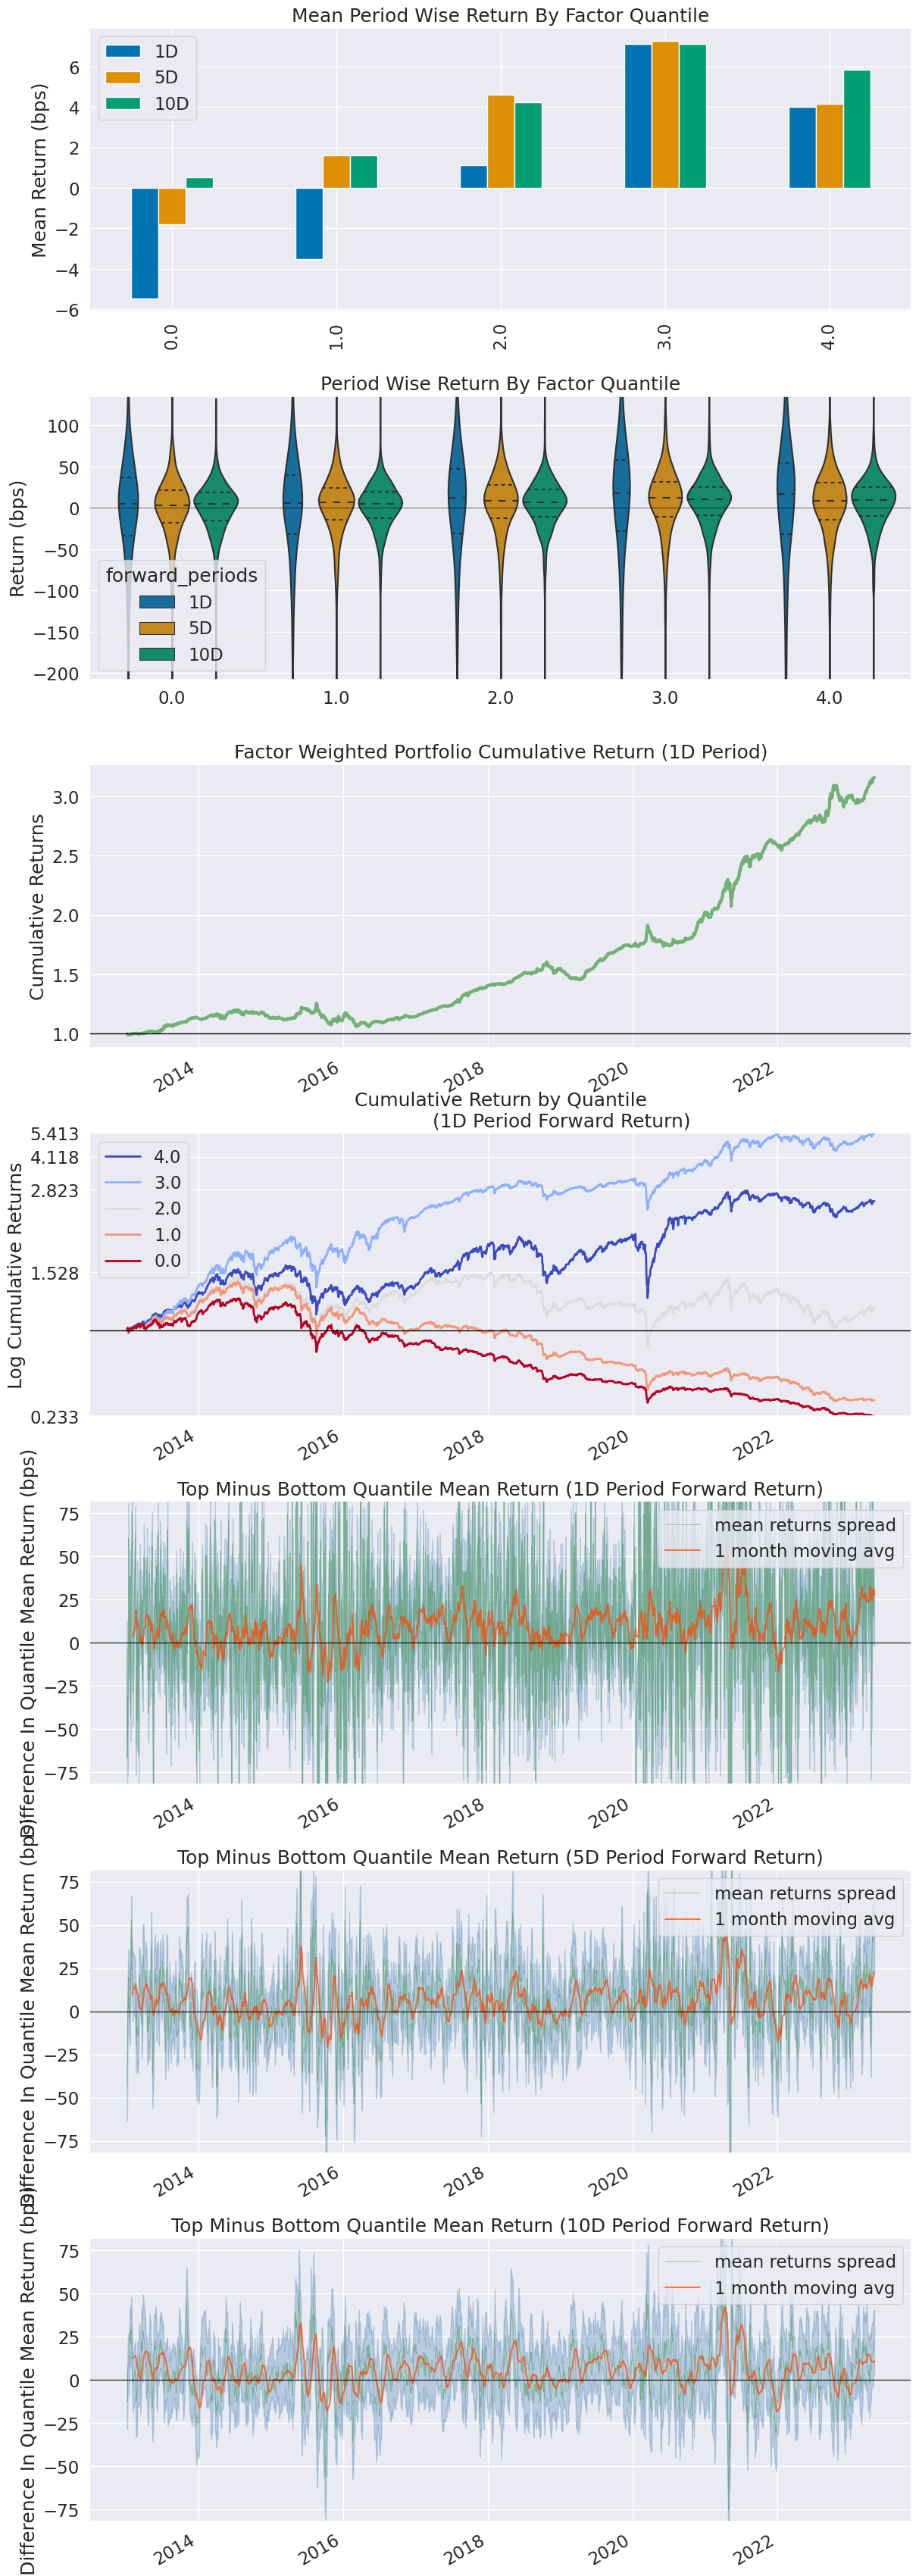

Information Analysis


1D      5D     10D
IC Mean           0.013   0.017   0.020
IC Std.           0.069   0.079   0.081
Risk-Adjusted IC  0.185   0.217   0.247
t-stat(IC)        9.312  10.907  12.418
p-value(IC)       0.000   0.000   0.000
IC Skew           0.046  -0.039  -0.099
IC Kurtosis       0.541  -0.013  -0.010

/usr/local/lib/python3.10/dist-packages/alphalens/plotting.py:217: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/usr/local/lib/python3.10/dist-packages/alphalens/plotting.py:275: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/usr/local/lib/python3.10/dist-packages/alphalens/plotting.py:276: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751


/usr/local/lib/python3.10/dist-packages/alphalens/plotting.py:276: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a 

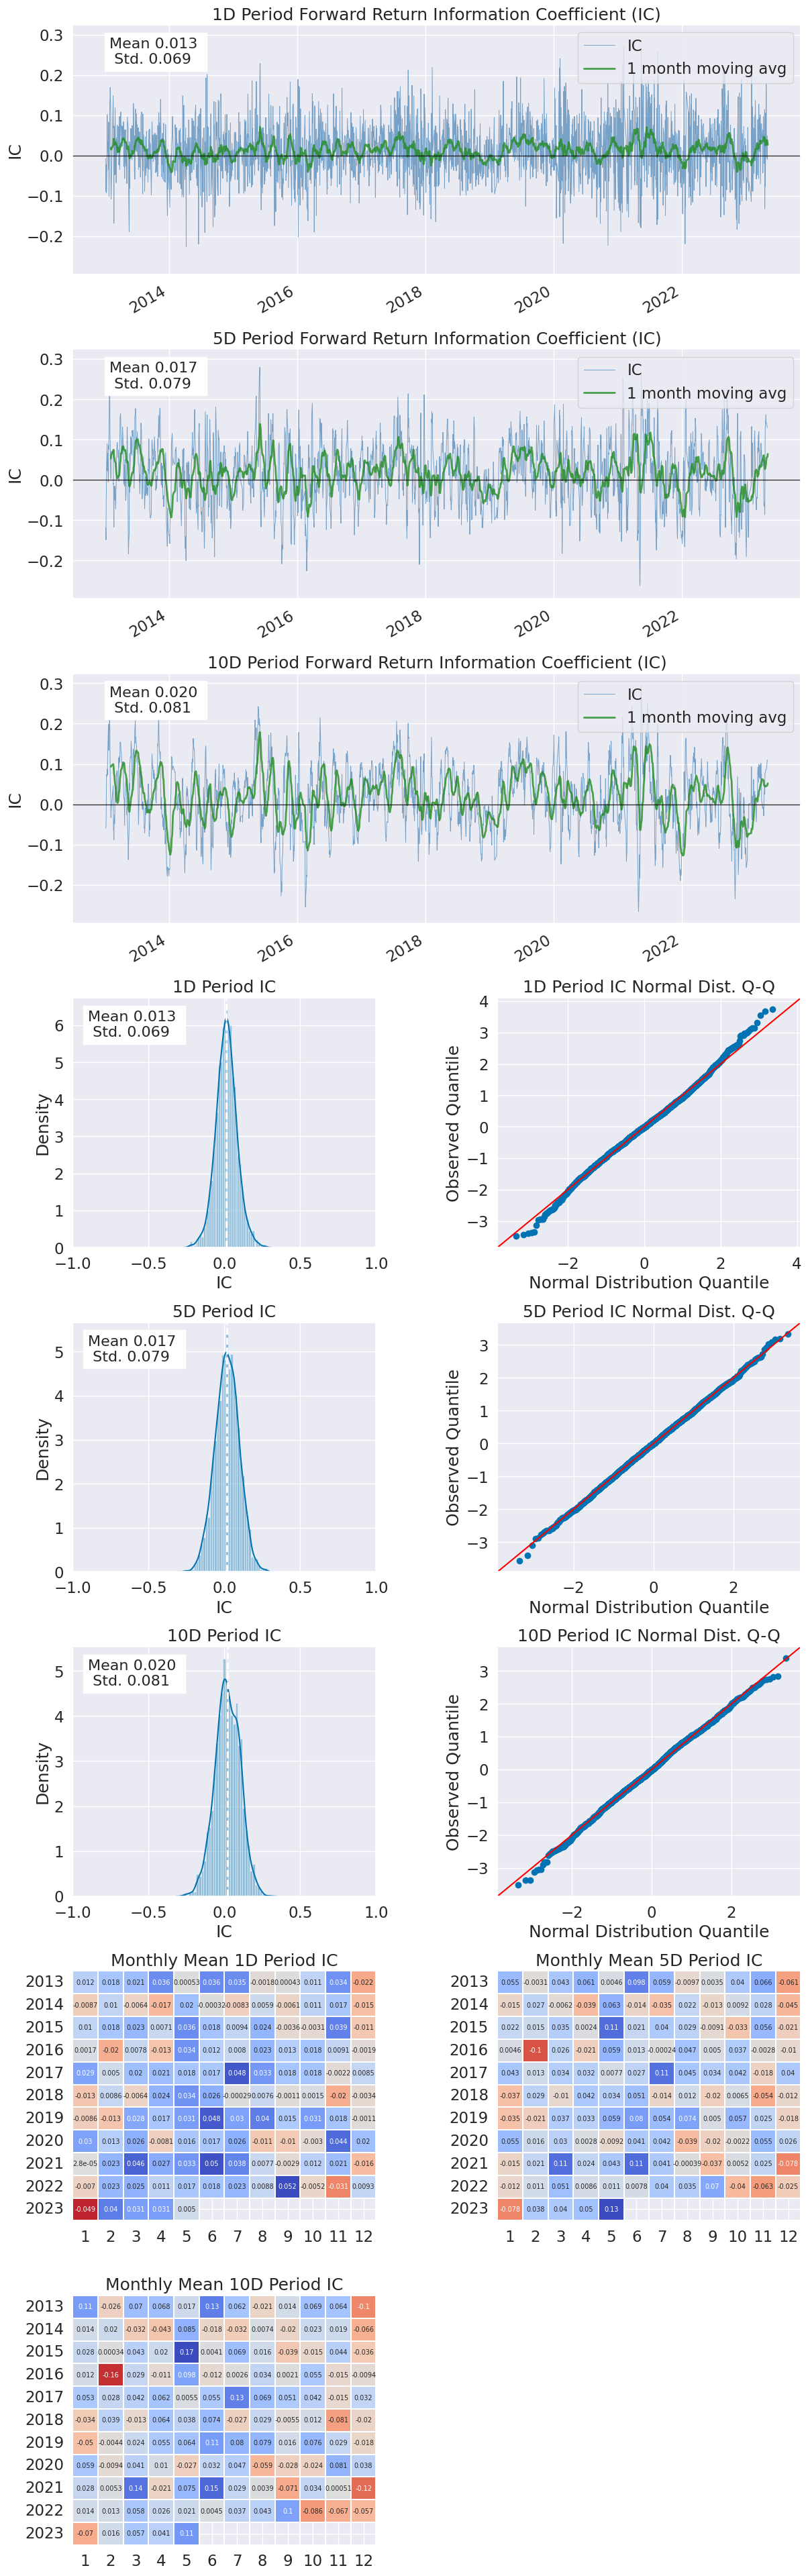

/usr/local/lib/python3.10/dist-packages/alphalens/utils.py:910: UserWarning:

Skipping return periods that aren't exact multiples of days.



Turnover Analysis


/usr/local/lib/python3.10/dist-packages/alphalens/plotting.py:153: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/usr/local/lib/python3.10/dist-packages/alphalens/plotting.py:153: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/usr/local/lib/python3.10/dist-packages/alphalens/plotting.py:153: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.

/usr/local/lib/python3.10/dist-packages/alphalens/plotting.py:157: FutureWarning:

iteritems is deprecated and will be removed in a future version. Use .items instead.



1D     5D    10D
Quantile 0.0 Mean Turnover   0.020  0.099  0.187
Quantile 1.0 Mean Turnover   0.041  0.206  0.358
Quantile 2.0 Mean Turnover   0.045  0.225  0.391
Quantile 3.0 Mean Turnover   0.044  0.219  0.374
Quantile 4.0 Mean Turnover   0.021  0.107  0.203

1D     5D    10D
Mean Factor Rank Autocorrelation  0.996  0.978  0.929

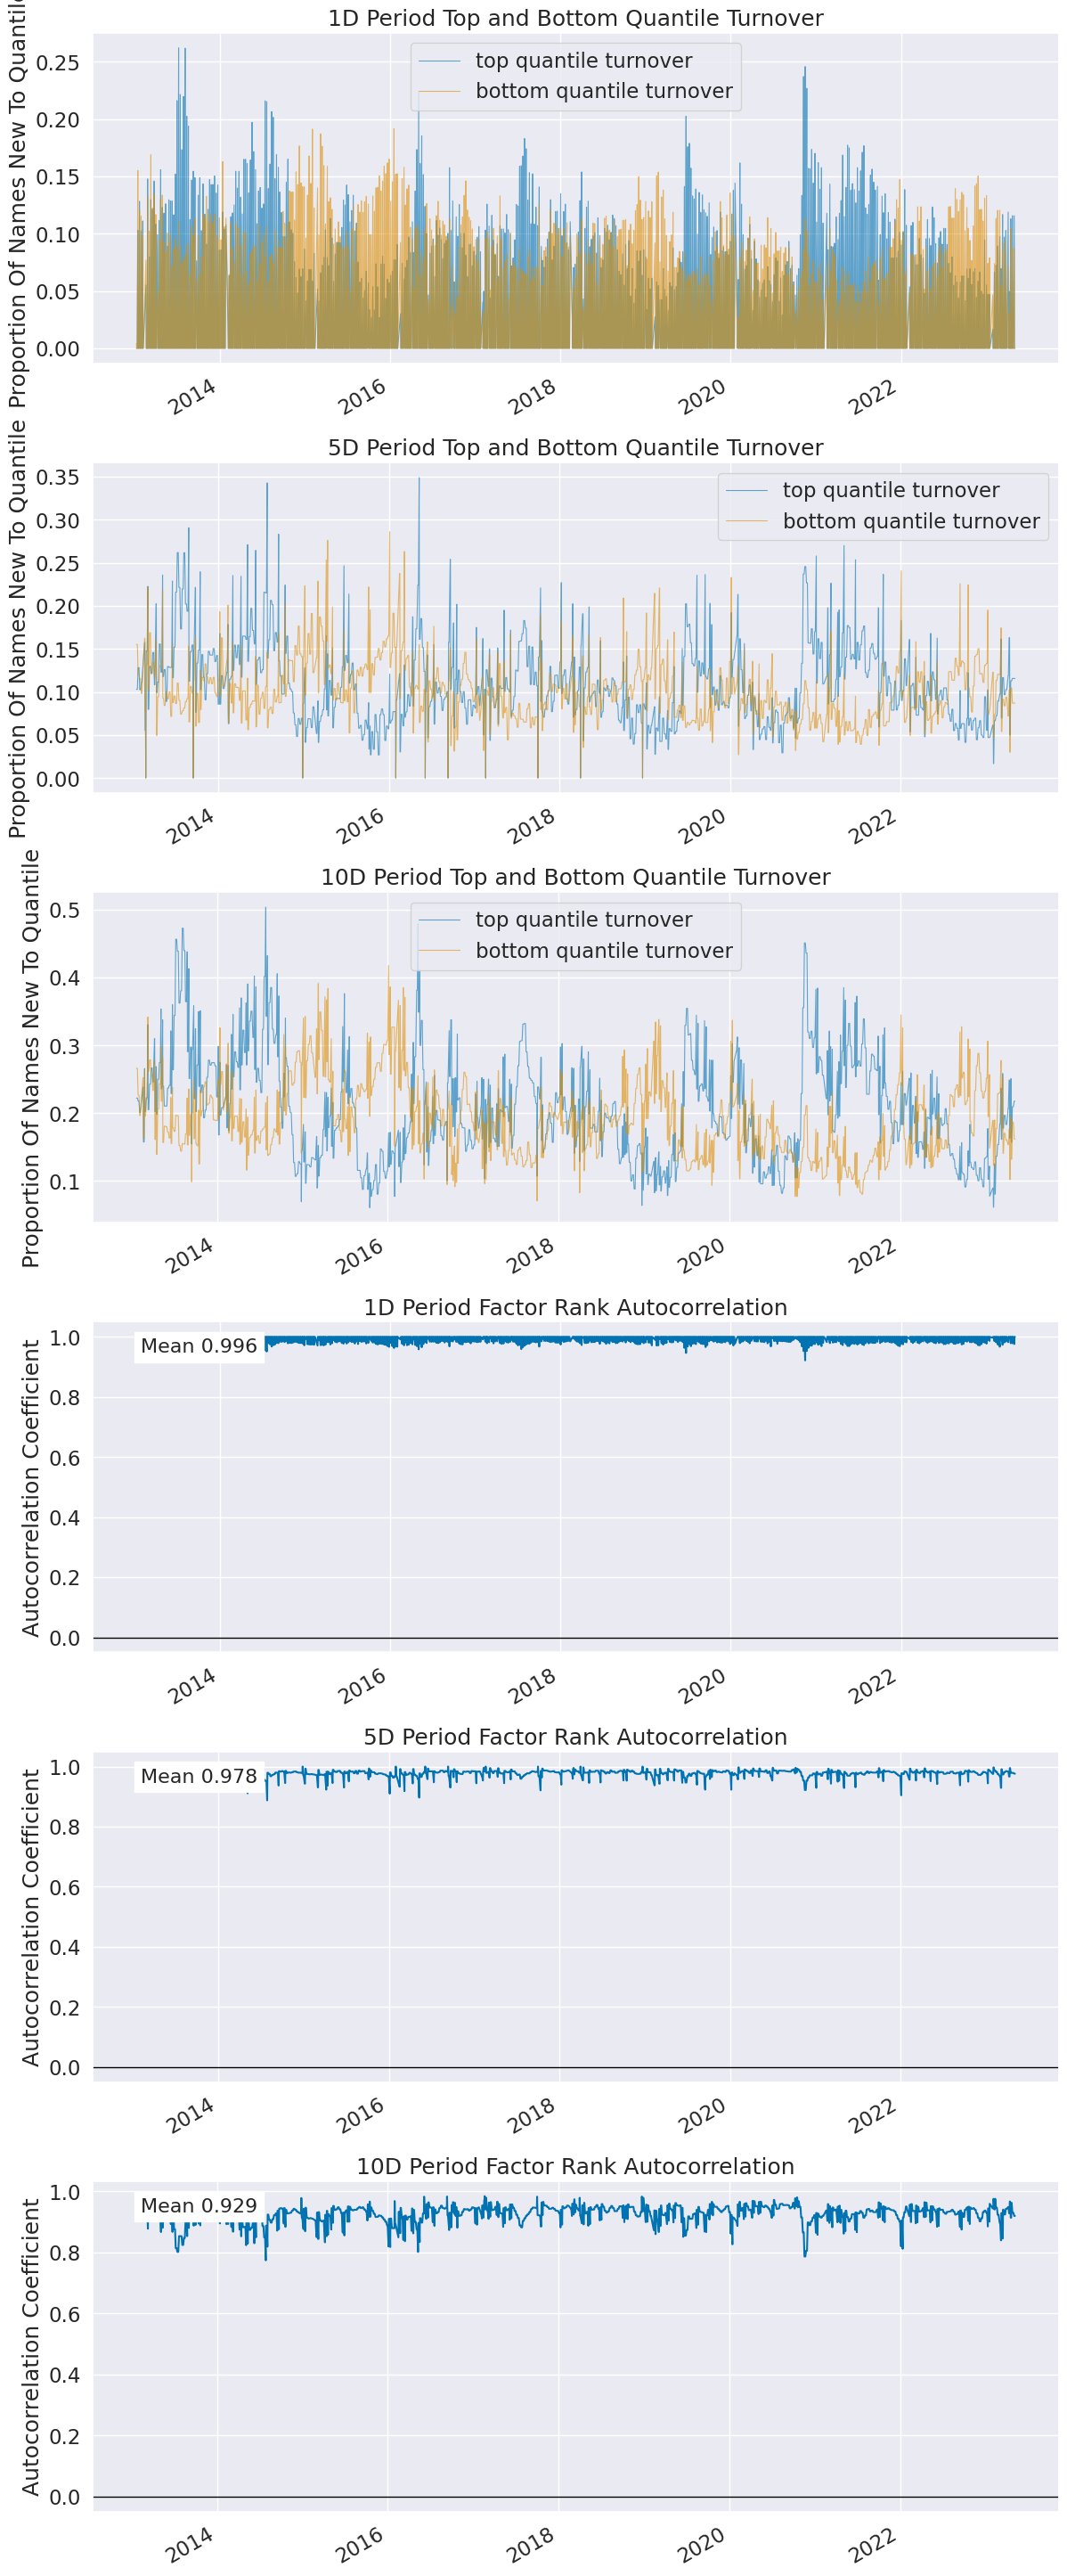

In [ ]:
#@title 因子分析
rebalance_frequency = "W" #@param {type:"string"}

import tqdm
import alphalens
from finlab import data
from finlab import backtest
from finlab.dataframe import FinlabDataFrame
from finlab.ml.alphalens import create_factor_data


def select_stocks(match_frequency, match_days, series_):
    close = data.get('price:收盤價')
    dates = pd.date_range('2013-01-01', close.index[-1], freq=rebalance_frequency)

    corrs = {}
    for d in tqdm.tqdm(dates):
        c, v = get_price(match_frequency, d, close_only=True)
        corr = find_best_match(series_, c, v)
        corrs[d] = corr

    return FinlabDataFrame(corrs).transpose()

corr = select_stocks(match_frequency, match_days, series_)

# factor analysis
adj_close = data.get('etl:adj_close')
factor = corr
factor_data = create_factor_data(factor, adj_close)
alphalens.tears.create_full_tear_sheet(factor_data.dropna(), long_short=False,
                                       group_neutral=False, by_group=False)

# 回測

In [ ]:
from finlab import data

close = data.get('price:收盤價')
position = (corr.is_largest(10))

r = backtest.sim(position, resample='M', fee_ratio=1.425/1000*0.3, tax_ratio=3/1000, upload=False)
r.display()

In [ ]:
# 將圖記錄起來
print(ys)

# 封裝成完整程式碼

In [ ]:
# 1. 執行此程式碼，並且複製下方的數字，就能將圖形保存起來
import json
json.dumps({'x': xs, 'y': ys})

'{"x": [34, 33, 37, 42, 49, 58, 65, 72, 78, 82, 84, 85, 86, 87, 88, 88, 90, 92, 94, 98, 103, 109, 114, 120, 126, 132, 137, 143, 147, 151, 154, 156, 158, 160, 162, 163, 165, 166, 168, 170, 171, 172, 173, 174, 176, 179, 185, 194, 205, 214, 222, 228, 233, 235, 237, 238, 238, 239, 240, 242, 243, 244, 245, 246, 248, 251, 254, 256, 259, 261, 263, 265, 267, 269, 273, 278, 284, 290, 298, 308, 319, 330, 340, 347, 351, 352, 353, 353, 353, 353], "y": [171, 168, 159, 148, 137, 125, 115, 108, 100, 95, 93, 92, 92, 91, 91, 91, 90, 90, 90, 89, 89, 89, 89, 89, 89, 91, 94, 98, 103, 107, 111, 115, 118, 121, 123, 125, 127, 129, 130, 131, 132, 133, 134, 134, 134, 132, 126, 117, 105, 95, 86, 78, 73, 71, 70, 69, 68, 68, 68, 67, 67, 67, 67, 68, 71, 76, 83, 90, 96, 100, 102, 104, 106, 107, 109, 111, 112, 113, 114, 111, 104, 95, 85, 78, 75, 73, 72, 72, 72, 71]}'

In [ ]:
# 策略完整程式碼
import tqdm
import numpy as np
import pandas as pd
from finlab import data
from finlab import backtest
from finlab.dataframe import FinlabDataFrame
from finlab.ml.alphalens import create_factor_data


# 將上方的數字複製貼上在這裡
drawing_data = {"x": [34, 33, 37, 42, 49, 58, 65, 72, 78, 82, 84, 85, 86, 87, 88, 88, 90, 92, 94, 98, 103, 109, 114, 120, 126, 132, 137, 143, 147, 151, 154, 156, 158, 160, 162, 163, 165, 166, 168, 170, 171, 172, 173, 174, 176, 179, 185, 194, 205, 214, 222, 228, 233, 235, 237, 238, 238, 239, 240, 242, 243, 244, 245, 246, 248, 251, 254, 256, 259, 261, 263, 265, 267, 269, 273, 278, 284, 290, 298, 308, 319, 330, 340, 347, 351, 352, 353, 353, 353, 353], "y": [171, 168, 159, 148, 137, 125, 115, 108, 100, 95, 93, 92, 92, 91, 91, 91, 90, 90, 90, 89, 89, 89, 89, 89, 89, 91, 94, 98, 103, 107, 111, 115, 118, 121, 123, 125, 127, 129, 130, 131, 132, 133, 134, 134, 134, 132, 126, 117, 105, 95, 86, 78, 73, 71, 70, 69, 68, 68, 68, 67, 67, 67, 67, 68, 71, 76, 83, 90, 96, 100, 102, 104, 106, 107, 109, 111, 112, 113, 114, 111, 104, 95, 85, 78, 75, 73, 72, 72, 72, 71]}
match_days = 200
match_frequency = 'D'
rebalance_frequency = 'W' # 每週換股

def create_series(drawing_data):
    series = (pd.DataFrame(drawing_data)
        .sort_values('x').groupby('x').mean()['y']
        .pipe(lambda s: 1 - (s - s.min()) / (s.max() - s.min()))
    )

    series_ = series[::int(max(len(series) / match_days, 1))].reset_index(drop=True)
    return series_

def get_price(freq, last_date=None, close_only=True):

    """依照頻率與日期索取股票的價格資料"""

    with data.universe('TSE_OTC'):

        close_ = data.get('price:收盤價').resample(freq).last().dropna(how='all').loc[:last_date].iloc[-len(series_):]
        vol_ = data.get('price:成交股數').resample(freq).last().dropna(how='all').loc[:last_date].iloc[-len(series_):]


        if not close_only:
            open_ = data.get('price:開盤價').resample(freq).last().dropna(how='all').loc[:last_date].iloc[-len(series_):]
            high_ = data.get('price:最高價').resample(freq).last().dropna(how='all').loc[:last_date].iloc[-len(series_):]
            low_ = data.get('price:最低價').resample(freq).last().dropna(how='all').loc[:last_date].iloc[-len(series_):]

    if close_only:
        return close_, vol_

    return close_, open_, high_, low_, vol_

def calc_corr_each_stock(series, close, vol_, min_vol=100000):

    """ 計算 correlation """

    corr = {}
    for sname, s in close.items():
        # if vol_[sname].iloc[-5:].mean() > min_vol:
        nor_s = (s - s.min()) / (s.max() - s.min())
        corr[sname] = np.corrcoef(series.values, nor_s.values)[0][1]

    corr = pd.Series(corr).sort_values().dropna()

    return corr

def calc_corr(match_frequency, match_days, series_):

    """計算每天每檔股票的 correlation """
    close = data.get('price:收盤價')
    dates = pd.date_range('2013-01-01', close.index[-1], freq=rebalance_frequency)

    corrs = {}
    for d in tqdm.tqdm(dates):
        c, v = get_price(match_frequency, d, close_only=True)
        corr = calc_corr_each_stock(series_, c, v)
        corrs[d] = corr

    return FinlabDataFrame(corrs).transpose()

series_ = create_series(drawing_data)
corr = calc_corr(match_frequency, match_days, series_)
position = corr.is_largest(10)
r = backtest.sim(position, resample='M', fee_ratio=1.425/1000*0.3, tax_ratio=3/1000, upload=False)
r.display()

annualized_rate_of_return sharpe max_drawdown win_ratio
                    19.28%   0.86      -33.59%    51.13%

entry_date exit_date entry_sig_date exit_sig_date  position  \
stock_id                                                                     
1773 勝一        2023-06-01       NaT     2023-05-31    2023-06-30       0.1   
1808 潤隆        2023-06-01       NaT     2023-05-31    2023-06-30       0.1   
2236 百達-KY     2023-06-01       NaT     2023-05-31    2023-06-30       0.1   
2897 王道銀行      2023-06-01       NaT     2023-05-31    2023-06-30       0.1   
2939 凱羿-KY     2023-06-01       NaT     2023-05-31    2023-06-30       0.1   
3006 晶豪科       2023-06-01       NaT     2023-05-31    2023-06-30       0.1   
3305 昇貿        2023-06-01       NaT     2023-05-31    2023-06-30       0.1   
3521 鴻翊        2023-06-01       NaT     2023-05-31    2023-06-30       0.1   
5299 杰力        2023-06-01       NaT     2023-05-31    2023-06-30       0.1   
6461 益得        2023-06-01       NaT     2023-05-31    2023-06-30       0.1   
1101 台泥               NaT       NaT     2023-06-30           NaT       NaN   
1103 嘉泥               NaT       NaT     2023-06-30           NaT       NaN   
1777 生泰               NaT       NaT     2023-06-30           NaT       NaN   
1786 科妍               NaT       NaT     2023-06-30           NaT       NaN   
2913 農林               NaT       NaT     2023-06-30           NaT       NaN   
3057 喬鼎               NaT       NaT     2023-06-30           NaT       NaN   
4561 健椿               NaT       NaT     2023-06-30           NaT       NaN   
6179 亞通               NaT       NaT     2023-06-30           NaT       NaN   
6741 91APP*-KY        NaT       NaT     2023-06-30           NaT       NaN   
8093 保銳               NaT       NaT     2023-06-30           NaT       NaN   

                period  entry_index  exit_index    return  \
stock_id                                                    
1773 勝一            8.0       3969.0        -1.0  0.022901   
1808 潤隆            8.0       3969.0        -1.0 -0.005270   
2236 百達-KY         8.0       3969.0        -1.0  0.045833   
2897 王道銀行          8.0       3969.0        -1.0 -0.004902   
2939 凱羿-KY         8.0       3969.0        -1.0 -0.031722   
3006 晶豪科           8.0       3969.0        -1.0  0.001151   
3305 昇貿            8.0       3969.0        -1.0 -0.050909   
3521 鴻翊            8.0       3969.0        -1.0  0.012658   
5299 杰力            8.0       3969.0        -1.0 -0.007491   
6461 益得            8.0       3969.0        -1.0 -0.079946   
1101 台泥            NaN          NaN         NaN       NaN   
1103 嘉泥            NaN          NaN         NaN       NaN   
1777 生泰            NaN          NaN         NaN       NaN   
1786 科妍            NaN          NaN         NaN       NaN   
2913 農林            NaN          NaN         NaN       NaN   
3057 喬鼎            NaN          NaN         NaN       NaN   
4561 健椿            NaN          NaN         NaN       NaN   
6179 亞通            NaN          NaN         NaN       NaN   
6741 91APP*-KY     NaN          NaN         NaN       NaN   
8093 保銳            NaN          NaN         NaN       NaN   

                trade_price@entry_date  trade_price@exit_date       mae  \
stock_id                                                                  
1773 勝一                          131.0                 134.00  0.000000   
1808 潤隆                           75.9                  75.50 -0.007905   
2236 百達-KY                        48.0                  50.20 -0.028125   
2897 王道銀行                         10.2                  10.15 -0.004902   
2939 凱羿-KY                        33.1                  32.05 -0.031722   
3006 晶豪科                          86.9                  87.00 -0.016110   
3305 昇貿                           55.0                  52.20 -0.060000   
3521 鴻翊                           23.7                  24.00  0.000000   
5299 杰力                          133.5                 132.50 -0.022472   
6461 益得                           36.9                  33.95 -0.079946   
1101 台泥                            NaN                 